<a id="top"></a>
# Water Observations from Space (WOFS)

<hr>

# Notebook Summary

This notebook demonstrates the Australian Water Observations from Space (WOFS) algorithm. This water detection algorithm is significantly better than the Landsat QA water flag or the NDWI index for water identification. 
<br><br>
For more information, visit this website: http://www.ga.gov.au/scientific-topics/hazards/flood/wofs

<hr>

# Index

* [Import Dependencies and Connect to the Data Cube](#import)
* [Choose Platforms and Products](#plat_prod)
* [Get the Extents of the Cube](#extents)
* [Define the Extents of the Analysis](#define_extents)
* [Load and Clean Data from the Data Cube](#load_data)
* [Time Series Water Detection Analysis](#time_series_water)
* [Create GeoTIFF Output Products](#export)

Set **nb_name** to the name of this notebook for storing files separately from copies of it.

In [1]:
nb_name = "DCAL_Water_WOFS"

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span>

In [2]:
# Enable importing of utilities.
import sys
import os
sys.path.append(os.environ.get('NOTEBOOK_ROOT'))

import numpy as np  
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Load Data Cube Configuration
import datacube
import utils.data_cube_utilities.data_access_api as dc_api

api = dc_api.DataAccessApi()
dc = api.dc

## <span id="plat_prod">Choose Platforms and Products [&#9652;](#top)</span>

**List available products for each platform**

In [3]:
# Get available products
products_info = dc.list_products()

# List LANDSAT 7 products
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


,platform,name
id,,
12,LANDSAT_7,ls7_collections_sr_scene
13,LANDSAT_7,ls7_ledaps_ghana
17,LANDSAT_7,ls7_ledaps_kenya
18,LANDSAT_7,ls7_ledaps_senegal
16,LANDSAT_7,ls7_ledaps_sierra_leone
19,LANDSAT_7,ls7_ledaps_tanzania
31,LANDSAT_7,ls7_ledaps_vietnam


In [4]:
# List LANDSAT 8 products
print("LANDSAT 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

LANDSAT 8 Products:


,platform,name
id,,
7,LANDSAT_8,ls8_collections_sr_scene
9,LANDSAT_8,ls8_lasrc_ghana
10,LANDSAT_8,ls8_lasrc_kenya
11,LANDSAT_8,ls8_lasrc_senegal
8,LANDSAT_8,ls8_lasrc_sierra_leone
15,LANDSAT_8,ls8_lasrc_tanzania


**Choose products**

<p style="color:red";><b>CHANGE INPUTS BELOW

In [5]:
# CHANGE HERE >>>>>>>>>>>>>>>>>

# Select a Product and Platform
product = "ls8_lasrc_kenya"
platform = "LANDSAT_8"

## <span id="extents">Get the Extents of the Cube [&#9652;](#top)</span>

In [6]:
from utils.data_cube_utilities.dc_load import get_product_extents
from utils.data_cube_utilities.dc_time import dt_to_str

full_lat, full_lon, min_max_dates = get_product_extents(api, platform, product)

# Print the extents of the combined data.
print("Latitude Extents:", full_lat)
print("Longitude Extents:", full_lon)
print("Time Extents:", list(map(dt_to_str, min_max_dates)))

Latitude Extents: (-4.997106940467012, 5.996881030410326)
Longitude Extents: (32.98674340708594, 41.9828951536269)
Time Extents: ['2013-04-12', '2020-01-19']


**Visualize the available area**

In [7]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(full_lat, full_lon)

## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

<p style="color:red";><b>CHANGE INPUTS BELOW

In [8]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# Be sure you check whether you are using L7 or L8 as the time extents are very different
# HINT: Keep your region small (<0.5 deg square) to avoid memory overload issues
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)
# This region and time period will be used for the water assessment

# Mombasa, Kenya
latitude_extents = (-4.0475, -3.9574) 
longitude_extents = (39.6028, 39.6792) 
time_extents = ('2015-01-01', '2016-12-31')

# L. Tanganyika, Tanzania
# latitude_extents = (-8.8901, -3.3042) 
# longitude_extents = (29.0069, 31.2510)
# time_extents = ('2016-01-01', '2017-01-01')

# L. Turkana, Kenya
# latitude_extents = ( 2.3248, 4.6859) 
# longitude_extents = (35.7751, 36.7639) 
# time_extents = ('2000-01-01', '2015-01-01')

# Ndakaini Dam, Kenya (provides water to Nairobi)
# latitude_extents =  (-0.8269, -0.8090) 
# longitude_extents =  (36.8192, 36.8529)
# time_extents = ('2000-01-01', '2018-01-01')

**Visualize the selected area**

In [9]:
display_map(latitude = latitude_extents, longitude = longitude_extents)

## <span id="load_data">Load and Clean Data from the Data Cube [&#9652;](#top)</span>
After loading, you will view the Xarray dataset. Notice the dimensions represent the number of pixels in your latitude and longitude dimension as well as the number of time slices (time) in your time series.

In [10]:
# Perform an empty load to create a blank dataset with correct dimensions.
landsat_dataset = dc.load(
    platform = platform,
    product = product,
    latitude = latitude_extents,
    longitude = longitude_extents,
    time = time_extents,
    measurements = [], # Do not load any measurements.
)
print(landsat_dataset)
ds_times = landsat_dataset.time # Save the acquisition dates for later
landsat_dataset = landsat_dataset.drop('time') # Drop time dimension

<xarray.Dataset>
Dimensions:      (latitude: 333, longitude: 284, time: 38)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-07T07:31:40 ... 2016-12-27T07:...
  * latitude     (latitude) float64 -3.957 -3.958 -3.958 ... -4.047 -4.048
  * longitude    (longitude) float64 39.6 39.6 39.6 39.6 ... 39.68 39.68 39.68
    spatial_ref  int32 4326
Data variables:
    *empty*
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref


In [11]:
# Create a new band which will be used to store total number of NON-CLOUD (land+water) pixels
landsat_dataset = landsat_dataset.assign({
    'count_total':
    xr.DataArray(
        np.zeros([d for d in landsat_dataset.dims.values()], dtype=np.uint16),
        dims=landsat_dataset.dims,
        coords=landsat_dataset.coords,
    ),
})
# Create a new band which will be used to store total number of WATER pixels (subset of NON-CLOUD)
landsat_dataset = landsat_dataset.assign({
    'count_water':
    xr.DataArray(
        np.zeros([d for d in landsat_dataset.dims.values()], dtype=np.uint16),
        dims=landsat_dataset.dims,
        coords=landsat_dataset.coords,
    ),
})
# Remove some attributes to allow saving of progress to NetCDF files.
del landsat_dataset.attrs['crs'], ds_times.attrs['units']
landsat_dataset

<xarray.Dataset>
Dimensions:      (latitude: 333, longitude: 284)
Coordinates:
  * latitude     (latitude) float64 -3.957 -3.958 -3.958 ... -4.047 -4.048
  * longitude    (longitude) float64 39.6 39.6 39.6 39.6 ... 39.68 39.68 39.68
    spatial_ref  int32 4326
Data variables:
    count_total  (latitude, longitude) uint16 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    count_water  (latitude, longitude) uint16 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
Attributes:
    grid_mapping:  spatial_ref

In [12]:
# This function just outputs a progress bar so I know things are still moving...
def progbar(progress, start_time=None, start_progress=0, msg='Progress:', bar_length=50):
    from IPython.display import clear_output
    import datetime
    
    # Clamp progress
    if not isinstance(progress, (float,int)): progress = 0;
    elif progress < 0: progress = 0;
    elif progress >= 1: progress = 1;
        
    # ETA
    if progress>0 and isinstance(start_time, datetime.datetime):
        cur_time = datetime.datetime.utcnow()
        
        per_step_dur = (cur_time - start_time)/(progress-start_progress)
        duration = per_step_dur*progress # Estimated processing duration until this point.
        
        eta_dur  = duration*(1-progress)/progress
        eta_time = cur_time + eta_dur
        time_str = "ETA: {eta} ({mins:.2f} min)".format(
            eta = str(eta_time.isoformat(' ', timespec='seconds')),
            mins = eta_dur.seconds / 60,
        )
    else: time_str ="";
        
    # Print it out
    blocks = int(round(bar_length * progress))
    clear_output(wait = True)
    print("{msg} [{bar}] {pct:.1f}% {time_str}".format( bar="#" * blocks + "-" * (bar_length - blocks), pct=progress * 100, msg=msg, time_str=time_str))
    
    return datetime.datetime.utcnow() # Return current time

In [13]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
from utils.data_cube_utilities.dc_water_classifier import wofs_classify
from utils.data_cube_utilities.dc_load import is_dataset_empty
import os
import pickle

# Create a DataArray to hold the per-acquisition water percentages.
timeslice_water_pct = xr.DataArray(np.full(len(ds_times), np.nan), name='timeslice_water_pct',
                                   dims=ds_times.dims, coords=ds_times.coords)
# Reset counters to zero (just in case we run this cell multiple times for some reason).
landsat_dataset.count_water.values*=0
landsat_dataset.count_total.values*=0

# Create geographic chunks.
from utils.data_cube_utilities.dc_chunker import create_geographic_chunks
geographic_chunks = create_geographic_chunks(longitude_extents, latitude_extents, 0.1)

tmp_dir = 'tmp/{}'.format(nb_name)
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Check if we are continuing the previous task (parameter set).
params_filepath = '{}/params.pkl'.format(tmp_dir) 
full_params = dict(platform=platform, product=product, 
                   latitude=latitude_extents, longitude=longitude_extents, time=time_extents,
                   measurements=['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa'])
continuing_task = False
if os.path.exists(params_filepath):
    with open(params_filepath, 'rb') as params_file:
        old_params = pickle.load(params_file)
        if old_params == full_params:
            continuing_task = True

progress_raster_file = "{}/progress_raster.nc".format(tmp_dir)
progress_time_ind_file = "{}/time_ind.pk".format(tmp_dir)
progress_timeslice_water_pct_file = "{}/timeslice_water.nc".format(tmp_dir)
            
# If the parameter set is new, record it and remove old progress files.
if not continuing_task:
    for root, dirs, files in os.walk(tmp_dir):
        for file in files:
            os.remove(os.path.join(root, file))
    with open(params_filepath, 'wb') as params_file:
        pickle.dump(full_params, params_file)
    
parameters = full_params.copy()
del parameters['time']

# Load the progress if any exists.
if os.path.exists(progress_raster_file):
    with xr.open_dataset(progress_raster_file) as raster_raster_file_handle:
        landsat_dataset = raster_raster_file_handle.load()
if os.path.exists(progress_time_ind_file):
    with open(progress_time_ind_file, 'rb') as pickle_file:
        last_completed_time_ind = pickle.load(pickle_file)
else:
    last_completed_time_ind = -1
if os.path.exists(progress_timeslice_water_pct_file):
    with xr.open_dataset(progress_timeslice_water_pct_file) as progress_timeslice_water_pct_file_handle:
        timeslice_water_pct = progress_timeslice_water_pct_file_handle.load().timeslice_water_pct

# Loop over all the time slices, processing each one.
start_progress = (last_completed_time_ind+1)/len(ds_times)
start_time = progbar(start_progress)
for time_ind,t in enumerate(ds_times.values):
    if time_ind <= last_completed_time_ind:
        continue
    parameters.update(dict(time=str(t)))
    
    timeslice_total_cloud = 0
    timeslice_total_water = 0
    
    # Process each geographic chunk for this time slice.
    for geo_chunk_ind, geographic_chunk in enumerate(geographic_chunks):
        if geo_chunk_ind == 0:
            print("Processing geographic chunks.")
        elif geo_chunk_ind % 5 == 0:
            print("Processed {:.3%} of all geographic chunks.".format(geo_chunk_ind / len(geographic_chunks)))
        
        landsat_slice_dict = dict(latitude=slice(*geographic_chunk['latitude'][::-1]),
                                  longitude=slice(*geographic_chunk['longitude']))
        geo_coords = landsat_dataset.sel(landsat_slice_dict).coords
        # Get the actual geographic extents of this data.
        geographic_chunk['latitude'] = geo_coords['latitude'][[0,-1]].values[::-1]
        geographic_chunk['longitude'] = geo_coords['longitude'][[0,-1]].values
        landsat_slice_dict = dict(latitude=slice(*geographic_chunk['latitude'][::-1]),
                                  longitude=slice(*geographic_chunk['longitude']))
        
        parameters.update(geographic_chunk)
        
        landsat_chunk = dc.load(**parameters)
        if is_dataset_empty(landsat_chunk):
            continue
        landsat_chunk = landsat_chunk.squeeze('time')
        
        # Mask Clouds
        cloud_mask = landsat_qa_clean_mask(landsat_chunk, platform=platform) # bool
        timeslice_total_cloud += cloud_mask.sum()
    
        # Add to total cloud-free pixel count.
        chunk_count_total = landsat_dataset.count_total.sel(landsat_slice_dict)
        chunk_count_total.values += cloud_mask.values
    
        # Classify Water
        water_mask = wofs_classify(landsat_chunk, clean_mask = cloud_mask.values, mosaic=True, no_data=0).wofs.astype(np.bool)
        timeslice_total_water += water_mask.sum()
    
        # Add to total water pixel count
        chunk_count_water = landsat_dataset.count_water.sel(landsat_slice_dict)
        chunk_count_water.values += water_mask.values

    # Compute percent of cloud-free pixels that are water for this timeslice.
    timeslice_water_pct[time_ind] = timeslice_total_water / timeslice_total_cloud
    
    # Save progress.
    if os.path.exists(progress_raster_file):
        os.remove(progress_raster_file)
    landsat_dataset.to_netcdf(progress_raster_file)
    if os.path.exists(progress_time_ind_file):
        os.remove(progress_time_ind_file)
    with open(progress_time_ind_file, 'wb') as pickle_file:
        pickle.dump(time_ind, pickle_file)
    if os.path.exists(progress_timeslice_water_pct_file):
        os.remove(progress_timeslice_water_pct_file)
    timeslice_water_pct.to_netcdf(progress_timeslice_water_pct_file)
    
    # Print progress bar
    progbar((time_ind+1)/len(ds_times), start_time, start_progress)
    
    # Plot time slice water percentages (except when all values are NaN, which causes an error).
    if ~np.all(np.isnan(timeslice_water_pct)):
        timeslice_water_pct.plot(figsize=(12,2), marker='o', linestyle='None')
        # plt.gca().set_yscale('log') # Change scaling of the Y axis to logarithmic
        plt.xlim(timeslice_water_pct.time.values[[0,-1]])
        plt.ylim(0, 1)
        plt.show()
    
    # Draw map as we go
    # landsat_dataset_low_res = xr_scale_res(landsat_dataset, frac_res=0.01)
    # plt.imshow(landsat_dataset_low_res.count_water / landsat_dataset_low_res.count_total, 
    #            aspect='equal')
    # plt.show()

progbar(1)
landsat_dataset

Progress: [##################################################] 100.0% 


<xarray.Dataset>
Dimensions:      (latitude: 333, longitude: 284)
Coordinates:
  * latitude     (latitude) float64 -3.957 -3.958 -3.958 ... -4.047 -4.048
  * longitude    (longitude) float64 39.6 39.6 39.6 39.6 ... 39.68 39.68 39.68
    spatial_ref  int32 4326
Data variables:
    count_total  (latitude, longitude) uint16 0 12 13 12 12 12 ... 0 0 0 0 0 0
    count_water  (latitude, longitude) uint16 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
Attributes:
    grid_mapping:  spatial_ref

## <span id="time_series_water">Time Series Water Detection Analysis [&#9652;](#top)</span>
Time series output of the Australian Water Detection from Space (WOFS) results. The results show the percent of time that a pixel is classified as water over the entire time series. BLUE = frequent water, RED = infrequent water.

In [14]:
# import color-scheme and set nans to black
from matplotlib.cm import jet_r as jet_r
import copy
jet_r = copy.copy(jet_r) # Copy to modify.
jet_r.set_bad('black',1)

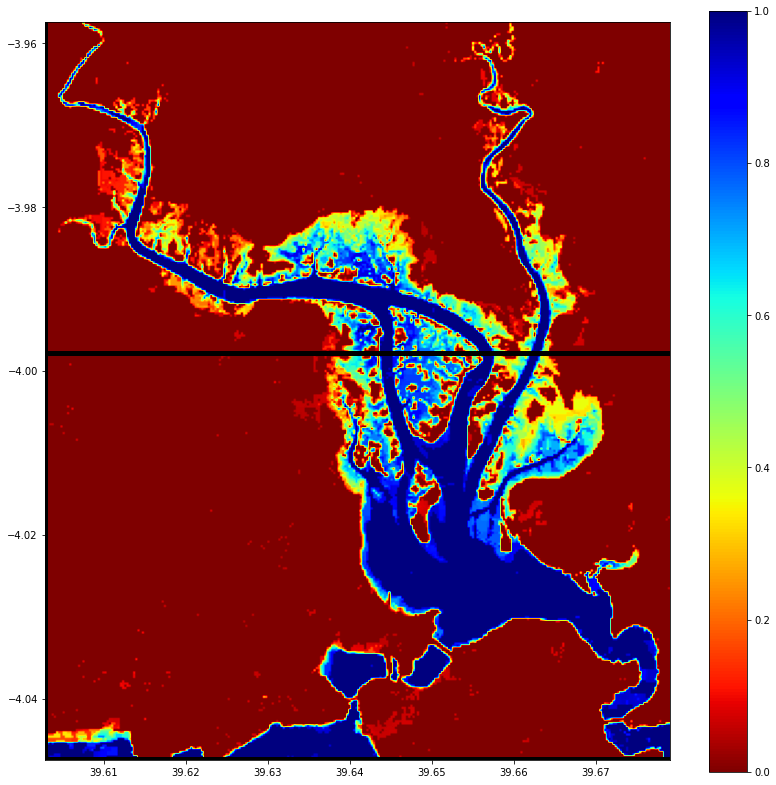

In [15]:
# Here we plot the product we have created
# Areas of RED have experienced little or no water over the time series
# Areas of BLUE have experience significant or constant water over the time series

tmp = landsat_dataset.count_water / landsat_dataset.count_total
fig,ax = plt.subplots(figsize=(14,14))
plt.imshow(tmp, cmap = jet_r, aspect="equal", extent=(
    landsat_dataset.longitude.min(),
    landsat_dataset.longitude.max(),
    landsat_dataset.latitude.min(),
    landsat_dataset.latitude.max(),
))
plt.colorbar()
plt.show()

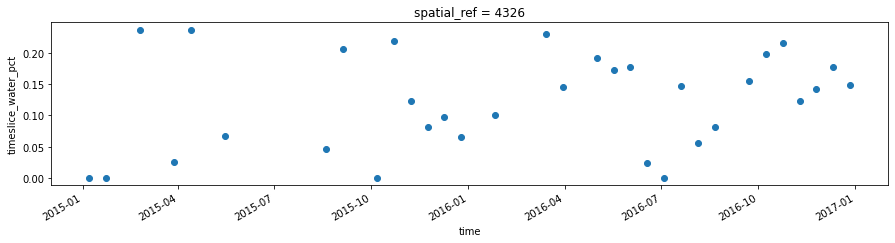

In [16]:
# Here we plot the percentage of valid (non-cloudy) pixels that were identified as water for each time slice

timeslice_water_pct.plot(figsize=(15,3), marker='o', linestyle='None')
plt.show()

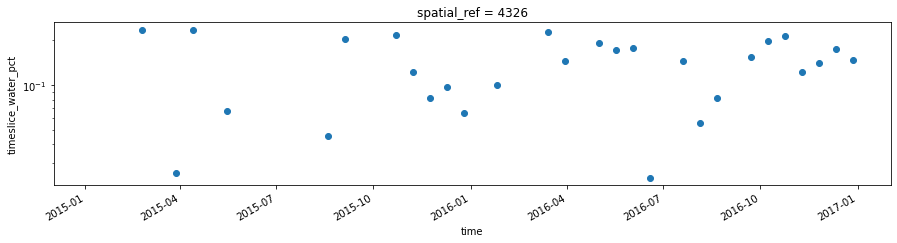

In [17]:
# It is often helpful to use a logarithmic scale when viewing these types of plots, as the "interesting"
# behavior tends to be clustered near zero and large outliers can hide small trends.
# The result below can be compared to the result above. 

timeslice_water_pct.plot(figsize=(15,3), marker='o', linestyle='None')
plt.gca().set_yscale('log') # Change scaling of the Y axis to logarithmic
plt.show()

## <span id="export">Create GeoTIFF Output Products [&#9652;](#top)</span>

In [18]:
# Save the water percentage image to a GeoTIFF.
from utils.data_cube_utilities.import_export import export_slice_to_geotiff

dataset_to_export = xr.Dataset(coords=landsat_dataset.coords, attrs=landsat_dataset.attrs)
dataset_to_export['wofs_pct'] = tmp.astype(np.float32).where(landsat_dataset.count_total>0)

<p style="color:red";><b>CHANGE INPUTS BELOW

In [19]:
# The export command below is commented out to avoid overwriting files. 
# If you would like to export data, please check the file path before uncommenting the line
# to ensure no files are accidentally lost.

output_dir = 'output/geotiffs'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
export_slice_to_geotiff(dataset_to_export, output_dir + '/WOFS_Percentage.tif')

In [20]:
!ls -lah output/geotiffs/WOFS_Percentage.tif

-rw-r--r-- 1 jovyan users 371K Sep 29 00:53 output/geotiffs/WOFS_Percentage.tif


In [21]:
!gdalinfo output/geotiffs/WOFS_Percentage.tif

Driver: GTiff/GeoTIFF
Files: output/geotiffs/WOFS_Percentage.tif
Size is 284, 333
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (39.602773977449679,-3.957450410572092)
Pixel Size = (0.000268630701983,-0.000270494373229)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (  39.6027740,  -3.9574504) ( 39d36' 9.99"E,  3d57'26.82"S)
Lower Left  (  39.6027740,  -4.0475250) ( 39d36' 9.99"E,  4d 2'51.09"S)
Upper Right (  